# Connecting to Git for version control and Google Drive to retrieve the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#connect to github repo
!git clone https://github.com/Austin-Gabriel/IEEE_Computer_Vision_Project.git

In [ ]:
cd /content/IEEE_Computer_Vision_Project/

/content/IEEE_Computer_Vision_Project


In [ ]:
!pwd

/content


# syncing to github

In [ ]:
#zip_directory = "/content/drive/MyDrive/data"
#new_directory = "/content/drive/MyDrive/satellite_data"
#zip_filenames = ['annotations.zip', 'uspp_landsat.zip', 'uspp_naip.zip']

#for zip_filename in zip_filenames:
#    zip_path = os.path.join(zip_directory, zip_filename)
#    with ZipFile(zip_path, 'r') as zip_file:
#        extraction_path = os.path.join(new_directory, zip_filename.replace('.zip', ''))
#        zip_file.extractall(extraction_path)
#        print(f"Extracted {zip_filename} to {extraction_path}")

In [ ]:
# Install rasterio

from PIL import Image
import numpy as np

# Load binary mask
binary_mask_path = '/content/drive/MyDrive/satellite_data/annotations/annotations/binary/bilabels_1002.png'
binary_mask = Image.open(binary_mask_path)
binary_array = np.array(binary_mask)

# Check if the mask has binary values
print("Unique values in binary mask:", np.unique(binary_array))

# Load a Landsat image using rasterio
landsat_path = '/content/drive/MyDrive/satellite_data/uspp_landsat/uspp_landsat/ls8_1002_CA_SUN.tif'
with rasterio.open(landsat_path) as src:
    landsat_image = src.read()  # Reads all bands
    print("Landsat image shape:", landsat_image.shape)  # Should be (bands, height, width)

# Load NAIP image
naip_path = '/content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_1002_CA_SUN.tif'
with rasterio.open(naip_path) as src:
    naip_image = src.read()
    print("NAIP image shape:", naip_image.shape)


Unique values in binary mask: [  0 255]


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Landsat image shape: (3, 76, 75)
NAIP image shape: (4, 1114, 1114)


In [ ]:
def read_10_naip_files(naip_folder_path):
  # Reads 10 NAIP files from the given folder.

  naip_files = []
  for filename in os.listdir(naip_folder_path):
    if filename.endswith('.tif'):
      naip_files.append(os.path.join(naip_folder_path, filename))
      if len(naip_files) == 10:
        break

  return naip_files

naip_folder_path = '/content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip'
naip_files = read_10_naip_files(naip_folder_path)

for naip_file in naip_files:
  with rasterio.open(naip_file) as src:
    naip_image = src.read()
    print(f"NAIP image shape for {naip_file}:", naip_image.shape)

NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4275_MN_SUB.tif: (4, 1115, 1114)
NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4276_MN_WAT.tif: (4, 1115, 1114)
NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4278_MN_WND.tif: (4, 1115, 1114)
NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4279_MN_WND.tif: (4, 1114, 1114)
NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4284_MN_WND.tif: (4, 1114, 1114)
NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4287_MN_WND.tif: (4, 1115, 1115)
NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4288_MN_WND.tif: (4, 1114, 1114)
NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4289_MN_WND.tif: (4, 1114, 1114)
NAIP image shape for /content/drive/MyDrive/satellite_data/uspp_

## Dataset Insights
1. The dataset contains 4,454 power plants across the US
2. The images come from two sources (NAIP 1m resolution and Landsat 8 30m resolution)
3. The naming convention for the landsat files are naip_253_AR_NG.tif or ls8_253_AR_NG.tif, contains:

    Power plant ID (e.g., 253).
    State Code (e.g., AR for Arkansas).
    Fuel Type Code (e.g., NG for natural gas).

4. The binary masks are used for marking the area covered by each power plant, used to guide the model's focus during training.
5. The confidence annotations aggregate outputs from the annotators to ensure accuracy and the accepted_ann_json.txt files contain detailed polygon boundaries.


# Setting up the data pipeline

In [ ]:
import glob
from torchvision import transforms
import torch

naip_path = '/content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip'
landsat_path = '/content/drive/MyDrive/satellite_data/uspp_landsat/uspp_landsat'
annotations_path = '/content/drive/MyDrive/satellite_data/annotations/annotations/binary'

transform = transforms.Compose([
    transforms.Resize((224,224)), # resize images
    transforms.ToTensor(), # covert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize images
])

In [ ]:
import os
import glob

def get_image_groups(naip_path, landsat_path, annotations_path):
    image_groups = {}
    plant_types = set()  # Use set to store unique plant types

    naip_files = glob.glob(os.path.join(naip_path, '*.tif'))
    landsat_files = glob.glob(os.path.join(landsat_path, '*.tif'))
    mask_files = glob.glob(os.path.join(annotations_path, '*.png'))

    # Organize by ID and extract fuel type
    for file_list, img_type in [(naip_files, 'NAIP'), (landsat_files, 'Landsat'), (mask_files, 'Mask')]:
        for file_path in file_list:
            base_name = os.path.basename(file_path)

            # Extract ID and type based on the file naming convention
            if img_type in ['NAIP', 'Landsat']:
                plant_id = base_name.split('_')[1]  # e.g., 'naip_4275_MN_SUB.tif' -> '4275'
                plant_type = base_name.split('_')[-1].split('.')[0]  # e.g., 'naip_4275_MN_SUB.tif' -> 'SUB'
                plant_types.add(plant_type)  # Add the plant type to the set of types
            elif img_type == 'Mask':
                plant_id = base_name.split('_')[1].split('.')[0]  # e.g., 'bilabels_4275.png' -> '4275'
                plant_type = image_groups.get(plant_id, {}).get('Type', 'Unknown')  # Use existing type if available

            # Initialize a new entry if not present
            if plant_id not in image_groups:
                image_groups[plant_id] = {'NAIP': None, 'Landsat': None, 'Mask': None, 'Type': plant_type}

            # Assign file path based on the type and store the type information
            image_groups[plant_id][img_type] = file_path
            image_groups[plant_id]['Type'] = plant_type  # Store plant type

    return image_groups, plant_types

image_groups, plant_types = get_image_groups(naip_path, landsat_path, annotations_path)

print("\nGrouped Image Data (Sample):")
for plant_id, images in list(image_groups.items())[:5]:
    print(f"Plant ID: {plant_id}")
    for img_type, path in images.items():
        print(f"  {img_type}: {path}")
    print("\n")



Grouped Image Data (Sample):
Plant ID: 4275
  NAIP: /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4275_MN_SUB.tif
  Landsat: /content/drive/MyDrive/satellite_data/uspp_landsat/uspp_landsat/ls8_4275_MN_SUB.tif
  Mask: /content/drive/MyDrive/satellite_data/annotations/annotations/binary/bilabels_4275.png
  Type: SUB


Plant ID: 4276
  NAIP: /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4276_MN_WAT.tif
  Landsat: /content/drive/MyDrive/satellite_data/uspp_landsat/uspp_landsat/ls8_4276_MN_WAT.tif
  Mask: /content/drive/MyDrive/satellite_data/annotations/annotations/binary/bilabels_4276.png
  Type: WAT


Plant ID: 4278
  NAIP: /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4278_MN_WND.tif
  Landsat: /content/drive/MyDrive/satellite_data/uspp_landsat/uspp_landsat/ls8_4278_MN_WND.tif
  Mask: /content/drive/MyDrive/satellite_data/annotations/annotations/binary/bilabels_4278.png
  Type: WND


Plant ID: 4279
  NAIP: /content/drive/MyDrive/satell

In [ ]:
print("Unique Plant Types in Dataset:")
for plant_type in sorted(plant_types):
    print(plant_type)

Unique Plant Types in Dataset:

AB
BFG
BIT
BLQ
COG
DFO
GEO
KER
LFG
LIG
MSW
MWH
NG
NUC
OBG
OBS
OG
OTH
PC
PRG
PUR
RFO
SGC
SLW
SUB
SUN
WAT
WC
WDL
WDS
WH
WND


# Preprocessing data
In this step we will
  1. Filter the dataset to include data from the six plants: Natural Gas, Subbituminous Coal, Natural Gas, Hydo, Solar and Wind
  2. Run exploratory stats on the data
  3. Display the sample images with the binary masks


In [ ]:
desired_types = {'WND', 'SUN', 'BIT', 'NG', 'WAT'}
filtered_image_groups = {
    plant_id: data
    for plant_id, data in image_groups.items()
    if data['NAIP'] and data['Mask'] and data['Type'] in desired_types
}

print(f"Before filtering: {len(image_groups)}")
print(f"After filtering: {len(filtered_image_groups)}")


Before filtering: 4454
After filtering: 2262


In [ ]:

total_count = len(image_groups)
remaining_count = len(filtered_image_groups)
dropped_count = total_count - remaining_count

# Count each type within the filtered dataset
type_counts = {}
for images in filtered_image_groups.values():
    plant_type = images['Type']
    type_counts[plant_type] = type_counts.get(plant_type, 0) + 1

# statistics
print(f"Images in original dataset: {total_count}")
print(f"Images remaining after filtering: {remaining_count}")
print(f"Images dropped: {dropped_count}\n")
print("Images in each category after filtering:")
for plant_type, count in type_counts.items():
    print(f"  {plant_type}: {count}")

# Display filtered sample
print("\nFiltered Image Data (Sample):")
for plant_id, data in list(filtered_image_groups.items())[:5]:
    print(f"Plant ID: {plant_id}")
    print(f"  NAIP: {data['NAIP']}")
    print(f"  Mask: {data['Mask']}")
    print(f"  Type: {data['Type']}")
    print()


Images in original dataset: 4454
Images remaining after filtering: 2262
Images dropped: 2192

Images in each category after filtering:
  WAT: 376
  WND: 296
  NG: 765
  SUN: 707
  BIT: 118

Filtered Image Data (Sample):
Plant ID: 4276
  NAIP: /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4276_MN_WAT.tif
  Mask: /content/drive/MyDrive/satellite_data/annotations/annotations/binary/bilabels_4276.png
  Type: WAT

Plant ID: 4278
  NAIP: /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4278_MN_WND.tif
  Mask: /content/drive/MyDrive/satellite_data/annotations/annotations/binary/bilabels_4278.png
  Type: WND

Plant ID: 4279
  NAIP: /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4279_MN_WND.tif
  Mask: /content/drive/MyDrive/satellite_data/annotations/annotations/binary/bilabels_4279.png
  Type: WND

Plant ID: 4284
  NAIP: /content/drive/MyDrive/satellite_data/uspp_naip/uspp_naip/naip_4284_MN_WND.tif
  Mask: /content/drive/MyDrive/satellite_data/an

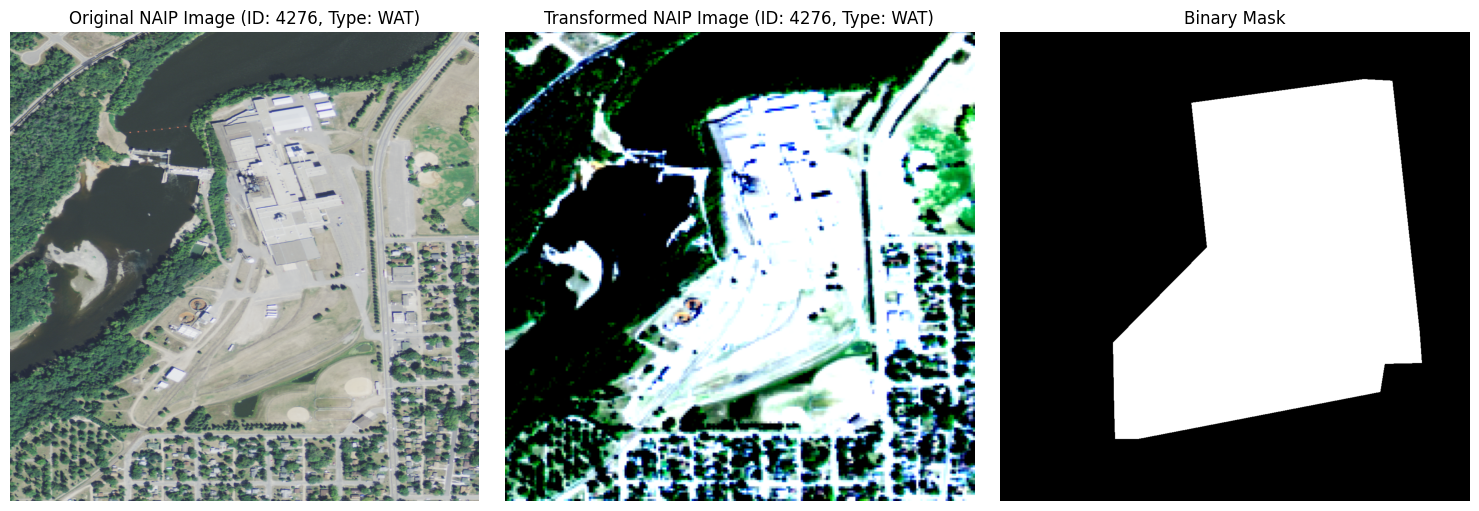

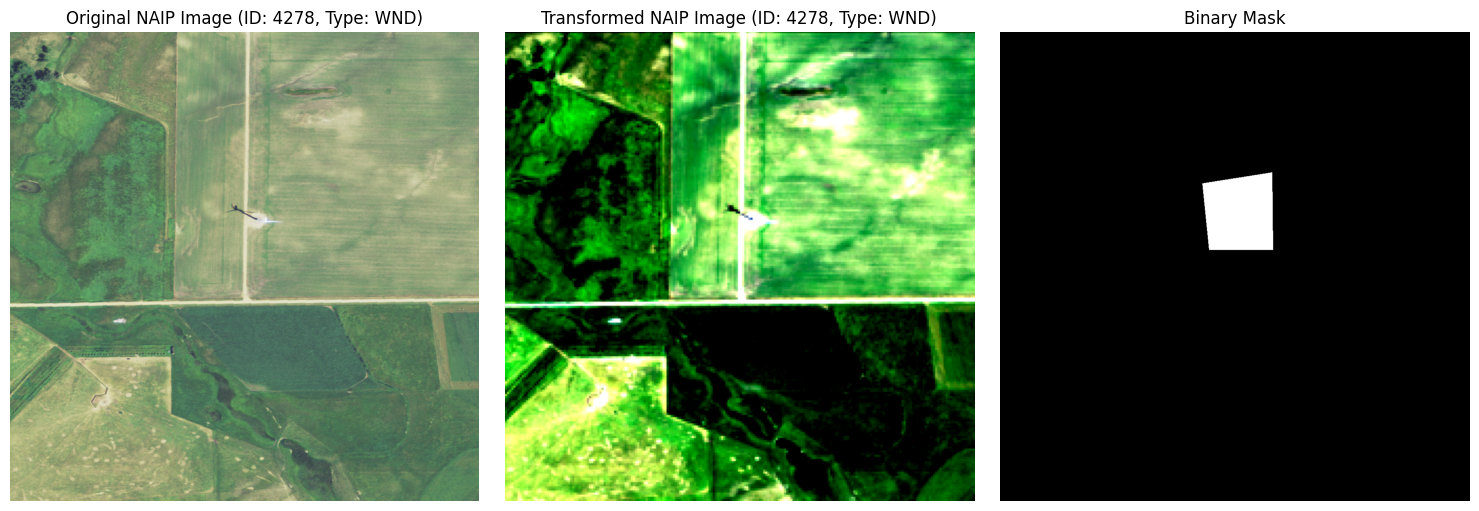

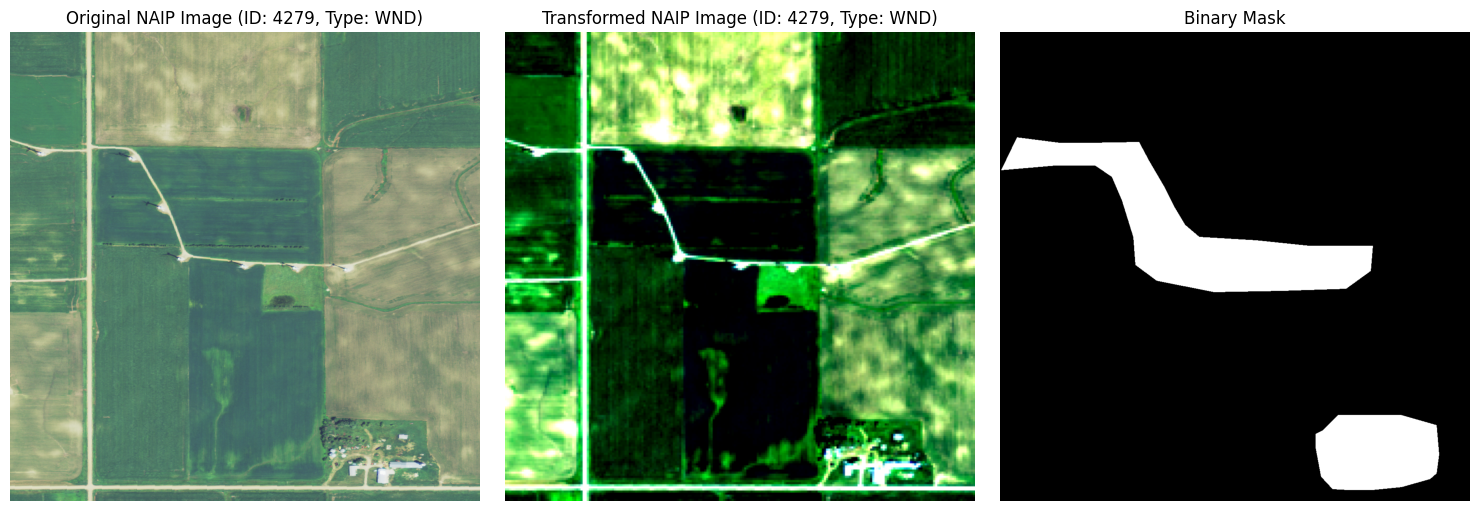

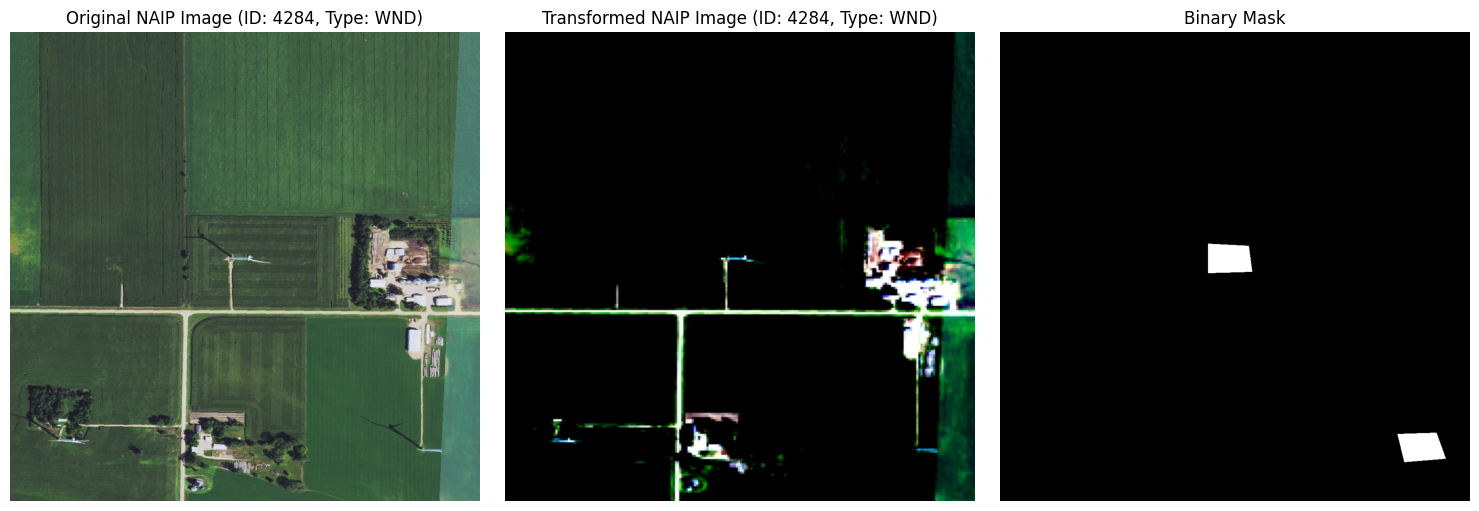

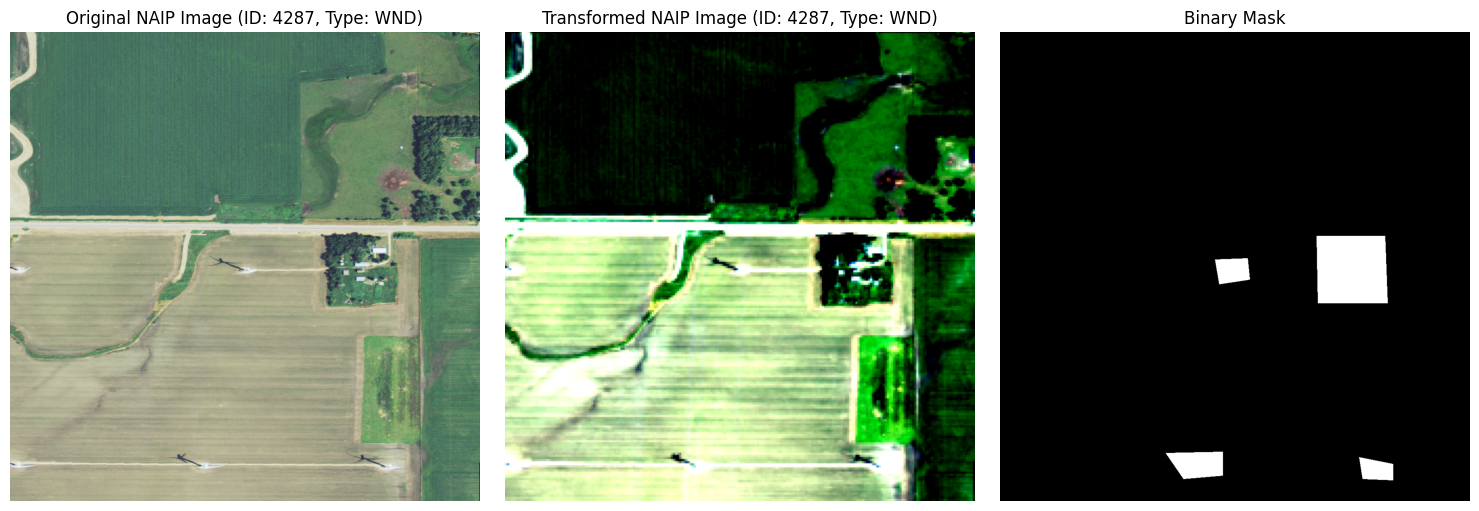

In [ ]:
import matplotlib.pyplot as plt

def display_sample_images(image_groups, transform, num_samples=5):
    sample_ids = list(image_groups.keys())[:num_samples]

    for plant_id in sample_ids:
        naip_image_path = image_groups[plant_id]['NAIP']
        mask_path = image_groups[plant_id]['Mask']
        plant_type = image_groups[plant_id]['Type']  # plant type

        if naip_image_path and mask_path:
            naip_image = Image.open(naip_image_path).convert('RGB')
            mask_image = Image.open(mask_path)

            # Transform image
            transformed_image = transform(naip_image)

            # Convert tensors to numpy array for display
            original_image_np = np.array(naip_image)
            transformed_image_np = transformed_image.permute(1, 2, 0).numpy()
            mask_np = np.array(mask_image)

            # original, transformed, and mask images
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            axs[0].imshow(original_image_np)
            axs[0].set_title(f"Original NAIP Image (ID: {plant_id}, Type: {plant_type})")
            axs[0].axis('off')

            axs[1].imshow(transformed_image_np)
            axs[1].set_title(f"Transformed NAIP Image (ID: {plant_id}, Type: {plant_type})")
            axs[1].axis('off')

            axs[2].imshow(mask_np, cmap='gray')
            axs[2].set_title('Binary Mask')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()

# sampke images with the function
display_sample_images(filtered_image_groups, transform)


# Model Development
The current goal is to build four models: The ViT-B/16 w/o masks,  ViT-B/16 w mask, GeoViT w/o masks, GeoVit w masks
  1. For data preparation the ViT processes images in patches (32x32,16x16 and 14x14 for the ViT-B/16, dependent on the trade off of finer patches for higher computational costs)
  2. Each power plant type has to be converted into a label:
    NG (Natural Gas) → 0
    SUN (Solar) → 1
    WND (Wind) → 2
    BIT (Bitumen) → 3
    WAT (Hydro) → 4


## ImageNet21k-pretrained ViT-B/16 without Binary Masks
We will be using the RGB channels in NAIP images and customizing the model output layer to match the five classes

## Data Split and Load Setup

In [ ]:
from sklearn.model_selection import train_test_split

# Extract IDs and types for stratified splitting
ids = list(filtered_image_groups.keys())
types = [filtered_image_groups[plant_id]['Type'] for plant_id in ids]

# Stratified test split
train_ids, test_ids = train_test_split(
    ids, test_size=0.3, stratify=types, random_state=42
)

print(f"Total IDs: {len(filtered_image_groups)}")
print(f"Train/Validation IDs: {len(train_ids)}")
print(f"Test IDs: {len(test_ids)}")

# distribution of test set
test_types = [filtered_image_groups[plant_id]['Type'] for plant_id in test_ids]
unique, counts = np.unique(test_types, return_counts=True)
print("\nTest set distribution by type:")
print(dict(zip(unique, counts)))


Total IDs: 2262
Train/Validation IDs: 1583
Test IDs: 679

Test set distribution by type:
{'BIT': 35, 'NG': 230, 'SUN': 212, 'WAT': 113, 'WND': 89}


In [ ]:
# k-Fold cross-validation setup
from sklearn.model_selection import StratifiedKFold

def k_fold_split(train_ids, filtered_image_groups):
  train_types = [filtered_image_groups[plant_id]['Type'] for plant_id in train_ids]
  skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

  folds = []
  for train_index, val_index in skf.split(train_ids, train_types):
    train_folds_ids = [train_ids[i] for i in train_index]
    val_folds_ids = [train_ids[i] for i in val_index]
    folds.append((train_folds_ids, val_folds_ids))

  return folds

folds = k_fold_split(train_ids, filtered_image_groups)

for i, (train_ids, val_ids) in enumerate(folds):
  print(f"\nFold {i+1}:")
  print(f"Training set size: {len(train_ids)}")
  print(f"Validation set size: {len(val_ids)}")

  val_types = [filtered_image_groups[plant_id]['Type'] for plant_id in val_ids]
  unique, counts = np.unique(val_types, return_counts=True)
  print("Validation set distribution by type:")
  print(dict(zip(unique, counts)))


Fold 1:
Training set size: 1187
Validation set size: 396
Validation set distribution by type:
{'BIT': 21, 'NG': 134, 'SUN': 124, 'WAT': 65, 'WND': 52}

Fold 2:
Training set size: 1187
Validation set size: 396
Validation set distribution by type:
{'BIT': 21, 'NG': 134, 'SUN': 124, 'WAT': 66, 'WND': 51}

Fold 3:
Training set size: 1187
Validation set size: 396
Validation set distribution by type:
{'BIT': 21, 'NG': 134, 'SUN': 123, 'WAT': 66, 'WND': 52}

Fold 4:
Training set size: 1188
Validation set size: 395
Validation set distribution by type:
{'BIT': 20, 'NG': 133, 'SUN': 124, 'WAT': 66, 'WND': 52}


Creating a Dataset Class

This class will:

    Take in the list of image IDs (from each fold).
    Load the NAIP image and corresponding mask for each ID.
    Apply transformations to prepare the images for input into the ViT model.

In [ ]:
# The code below is for the dataset without masks

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch

class PowerPlantDataset(Dataset):
    def __init__(self, image_groups, ids, transform, use_mask=False):
        self.image_groups = image_groups
        self.ids = ids
        self.transform = transform
        self.use_mask = use_mask  # Flag to control if we load masks

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        plant_id = self.ids[idx]
        naip_path = self.image_groups[plant_id]['NAIP']
        label = self.get_label(self.image_groups[plant_id]['Type'])

        # Load and transform the NAIP image
        naip_image = Image.open(naip_path).convert('RGB')
        if self.transform:
            naip_image = self.transform(naip_image)

        # Only load the mask if `use_mask` is True
        if self.use_mask:
            mask_path = self.image_groups[plant_id]['Mask']
            mask_image = Image.open(mask_path)
            mask_image = torch.tensor(np.array(mask_image), dtype=torch.float32).unsqueeze(0)
            mask_image = torch.nn.functional.interpolate(
                mask_image.unsqueeze(0), size=(224, 224), mode='nearest'
            ).squeeze(0)
            return naip_image, mask_image, label
        else:
            return naip_image, label  # Return only NAIP image and label

    def get_label(self, plant_type):
        type_to_label = {'WND': 0, 'SUN': 1, 'BIT': 2, 'NG': 3, 'WAT': 4}
        return type_to_label.get(plant_type, -1)

# Creating DataLoader without masks for training and validation
train_dataset = PowerPlantDataset(filtered_image_groups, train_ids, transform, use_mask=False)
val_dataset = PowerPlantDataset(filtered_image_groups, val_ids, transform, use_mask=False)
test_dataset = PowerPlantDataset(filtered_image_groups, test_ids, transform, use_mask=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from torch.nn.functional import softmax

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to GPU/CPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        predictions = torch.argmax(softmax(outputs, dim=1), dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100

    return avg_loss, accuracy

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Accuracy
            predictions = torch.argmax(softmax(outputs, dim=1), dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total * 100

    return avg_loss, accuracy


In [ ]:
# upgraded to collab pro
gpu_info = !nvidia-smi
print("\n".join(gpu_info))

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} GB of available RAM")


Mon Nov 25 03:20:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import torch.nn as nn
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
model.classifier = nn.Linear(model.config.hidden_size, 5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")


KeyboardInterrupt: 

In [ ]:
save_path = '/content/drive/MyDrive/models/vit_model_no_mask.pth'

torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/models/vit_model_no_mask.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Load the model from Google Drive
load_path = '/content/drive/MyDrive/models/vit_model_no_mask.pth'
model.load_state_dict(torch.load(load_path))
model.to(device)
print(f"Model loaded from {load_path}")

<ipython-input-29-f2b9a42de2bd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


Model loaded from /content/drive/MyDrive/models/vit_model_no_mask.pth


In [ ]:
!mkdir -p /content/drive/MyDrive/models

In [ ]:
# Testing the model
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.6488, Test Accuracy: 79.53%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=['NG', 'SUN', 'WND', 'BIT', 'WAT']))


[[ 72   9   0   7   1]
 [  6 195   0  10   1]
 [  0   0   5  30   0]
 [  0  47   0 181   2]
 [  3  17   0  12  81]]
              precision    recall  f1-score   support

          NG       0.89      0.81      0.85        89
         SUN       0.73      0.92      0.81       212
         WND       1.00      0.14      0.25        35
         BIT       0.75      0.79      0.77       230
         WAT       0.95      0.72      0.82       113

    accuracy                           0.79       679
   macro avg       0.86      0.68      0.70       679
weighted avg       0.81      0.79      0.77       679



# VIT-B/16 Model with MASKS

In [ ]:
import os
from PIL import Image, UnidentifiedImageError
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold

# Exclude invalid masks
def exclude_invalid_masks(image_groups):
    valid_image_groups = {}
    excluded_ids = []

    for plant_id, data in image_groups.items():
        try:
            mask_path = data['Mask']
            if mask_path:
                # Attempt to open the mask to verify it's valid
                Image.open(mask_path)
            valid_image_groups[plant_id] = data
        except (UnidentifiedImageError, FileNotFoundError, ValueError):
            excluded_ids.append(plant_id)

    return valid_image_groups, excluded_ids

# Apply exclusion
filtered_image_groups, excluded_ids = exclude_invalid_masks(filtered_image_groups)
print(f"Excluded {len(excluded_ids)} IDs with invalid masks.")

# Train-test split
ids = list(filtered_image_groups.keys())
types = [filtered_image_groups[plant_id]['Type'] for plant_id in ids]

train_ids, test_ids = train_test_split(
    ids, test_size=0.3, stratify=types, random_state=42
)

print(f"Total IDs: {len(filtered_image_groups)}")
print(f"Train IDs: {len(train_ids)}")
print(f"Test IDs: {len(test_ids)}")

# Stratified K-Fold for cross-validation
def k_fold_split(train_ids, filtered_image_groups):
    train_types = [filtered_image_groups[plant_id]['Type'] for plant_id in train_ids]
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    folds = []
    for train_index, val_index in skf.split(train_ids, train_types):
        train_folds_ids = [train_ids[i] for i in train_index]
        val_folds_ids = [train_ids[i] for i in val_index]
        folds.append((train_folds_ids, val_folds_ids))

    return folds

folds = k_fold_split(train_ids, filtered_image_groups)


Excluded 1 IDs with invalid masks.
Total IDs: 2261
Train IDs: 1582
Test IDs: 679


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

# Dataset class
class PowerPlantDatasetWithMasks(Dataset):
    def __init__(self, image_groups, ids, transform, use_mask=True):
        self.image_groups = image_groups
        self.ids = ids
        self.transform = transform
        self.use_mask = use_mask

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        plant_id = self.ids[idx]
        naip_path = self.image_groups[plant_id]['NAIP']
        mask_path = self.image_groups[plant_id]['Mask'] if self.use_mask else None
        label = self.get_label(self.image_groups[plant_id]['Type'])

        # Load and transform the NAIP image
        naip_image = Image.open(naip_path).convert('RGB')
        if self.transform:
            naip_image = self.transform(naip_image)

        # Load mask if applicable
        if self.use_mask:
            mask_image = Image.open(mask_path)
            mask_tensor = torch.tensor(np.array(mask_image), dtype=torch.float32).unsqueeze(0)
            mask_tensor = torch.nn.functional.interpolate(
                mask_tensor.unsqueeze(0), size=(224, 224), mode='nearest'
            ).squeeze(0)
            return naip_image, mask_tensor, label
        else:
            return naip_image, label

    def get_label(self, plant_type):
        type_to_label = {'WND': 0, 'SUN': 1, 'BIT': 2, 'NG': 3, 'WAT': 4}
        return type_to_label.get(plant_type, -1)


In [ ]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create datasets
train_dataset_with_masks = PowerPlantDatasetWithMasks(filtered_image_groups, train_ids, transform, use_mask=True)
test_dataset_with_masks = PowerPlantDatasetWithMasks(filtered_image_groups, test_ids, transform, use_mask=True)

# Create loaders
train_loader_with_masks = DataLoader(train_dataset_with_masks, batch_size=32, shuffle=True)
test_loader_with_masks = DataLoader(test_dataset_with_masks, batch_size=32, shuffle=False)

# Prepare fold DataLoaders for cross-validation
fold_data_loaders = []
for train_fold, val_fold in folds:
    train_dataset = PowerPlantDatasetWithMasks(filtered_image_groups, train_fold, transform, use_mask=True)
    val_dataset = PowerPlantDatasetWithMasks(filtered_image_groups, val_fold, transform, use_mask=True)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    fold_data_loaders.append((train_loader, val_loader))


In [ ]:
import torch.nn as nn
from transformers import ViTForImageClassification

# Define the fusion model
class FusionModelWithMasks(nn.Module):
    def __init__(self, base_model):
        super(FusionModelWithMasks, self).__init__()
        self.base_model = base_model  # Pretrained no-mask ViT model

        # Additional CNN for processing masks
        self.mask_cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((14, 14)),  # Match ViT patch size
        )

        # Fully connected layer for combining features
        self.fusion_fc = nn.Linear(base_model.config.hidden_size + 32 * 14 * 14, base_model.config.hidden_size)

    def forward(self, images, masks):
        # Get features from image using base ViT model
        image_features = self.base_model.vit(images).last_hidden_state[:, 0, :]  # CLS token features

        # Process the binary mask
        mask_features = self.mask_cnn(masks)
        mask_features = mask_features.view(mask_features.size(0), -1)  # Flatten

        # Concatenate image and mask features
        combined_features = torch.cat((image_features, mask_features), dim=1)

        # Pass through fusion layer
        fused_features = self.fusion_fc(combined_features)

        # Final classification
        logits = self.base_model.classifier(fused_features)
        return logits


In [ ]:
# Load pretrained no-mask model
no_mask_model_path = '/content/drive/MyDrive/models/vit_model_no_mask.pth'
model_without_masks = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
model_without_masks.classifier = nn.Linear(model_without_masks.config.hidden_size, 5)
model_without_masks.load_state_dict(torch.load(no_mask_model_path))

# Initialize Fusion Model
fusion_model = FusionModelWithMasks(model_without_masks).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=5e-5)

# Training loop
num_epochs = 3

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-26-8860eac5d1fc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

NameError: name 'device' is not defined

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(fusion_model, train_loader_with_masks, criterion, optimizer, device)
    val_loss, val_acc = validate(fusion_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")


Epoch 1/3
Train Loss: 4.2083, Train Accuracy: 41.53%
Validation Loss: 1.4664, Validation Accuracy: 66.33%

Epoch 2/3
Train Loss: 1.1909, Train Accuracy: 73.32%
Validation Loss: 0.7463, Validation Accuracy: 81.52%

Epoch 3/3
Train Loss: 0.7498, Train Accuracy: 84.01%
Validation Loss: 0.2088, Validation Accuracy: 94.43%



KeyboardInterrupt: 

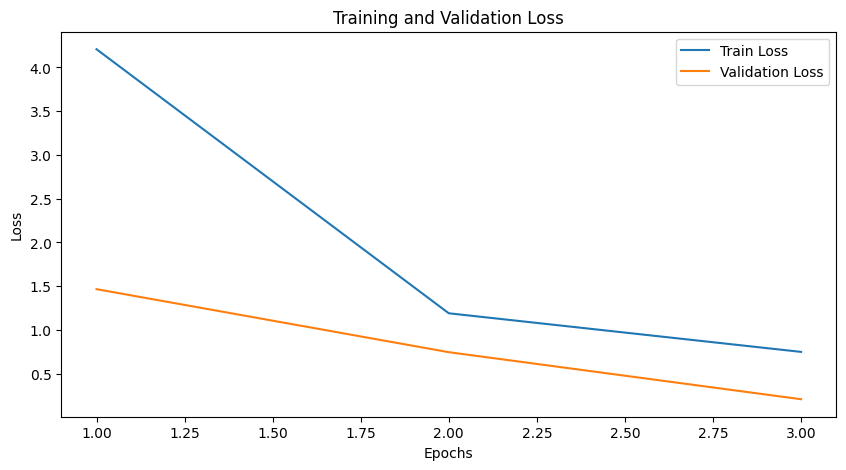

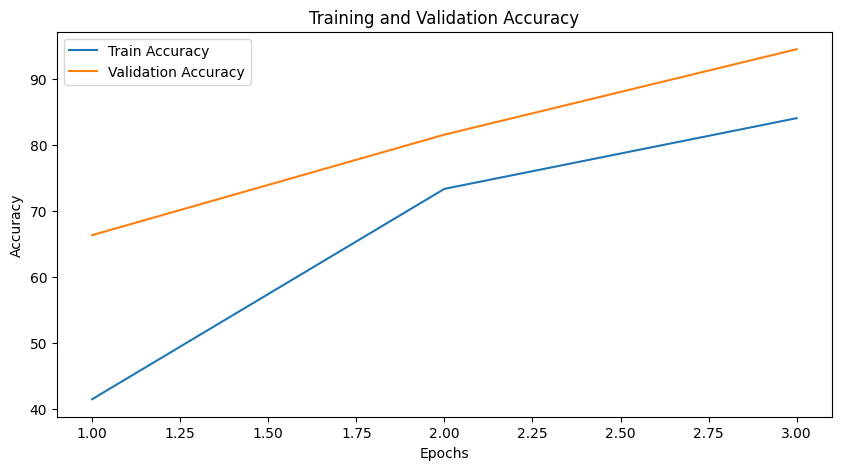

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_on_test(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, masks, labels in test_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, masks)  # Forward pass
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['WND', 'SUN', 'BIT', 'NG', 'WAT']))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


In [ ]:
evaluate_on_test(fusion_model, test_loader_with_masks, device)


Classification Report:
              precision    recall  f1-score   support

         WND       0.85      0.75      0.80        89
         SUN       0.75      0.86      0.80       212
         BIT       0.38      0.40      0.39        35
          NG       0.81      0.69      0.75       230
         WAT       0.75      0.81      0.78       113

    accuracy                           0.76       679
   macro avg       0.71      0.70      0.70       679
weighted avg       0.76      0.76      0.76       679


Confusion Matrix:
[[ 67   6   1   7   8]
 [  7 183   5   8   9]
 [  2   1  14  13   5]
 [  2  47  14 159   8]
 [  1   8   3   9  92]]


In [ ]:
save_path = '/content/drive/MyDrive/models/vit_model_with_mask.pth'

torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/models/vit_model_with_mask.pth


## Retrain a new model with k-fold validation

In [ ]:
import os
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Exclude invalid masks
def exclude_invalid_masks(image_groups):
    valid_image_groups = {}
    excluded_ids = []

    for plant_id, data in image_groups.items():
        try:
            mask_path = data['Mask']
            if mask_path:
                Image.open(mask_path)  # Verify the mask is valid
            valid_image_groups[plant_id] = data
        except (UnidentifiedImageError, FileNotFoundError, ValueError):
            excluded_ids.append(plant_id)

    return valid_image_groups, excluded_ids


Excluded 0 IDs with invalid masks.
Excluded IDs: []


In [ ]:
# Dataset class
class PowerPlantDatasetWithMasks(Dataset):
    def __init__(self, image_groups, ids, transform, use_mask=True):
        self.image_groups = image_groups
        self.ids = ids
        self.transform = transform
        self.use_mask = use_mask

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        plant_id = self.ids[idx]
        naip_path = self.image_groups[plant_id]['NAIP']
        mask_path = self.image_groups[plant_id]['Mask'] if self.use_mask else None
        label = self.get_label(self.image_groups[plant_id]['Type'])

        # Load and transform the NAIP image
        naip_image = Image.open(naip_path).convert('RGB')
        if self.transform:
            naip_image = self.transform(naip_image)

        # Load mask if applicable
        if self.use_mask:
            mask_image = Image.open(mask_path)
            mask_tensor = torch.tensor(np.array(mask_image), dtype=torch.float32).unsqueeze(0)
            mask_tensor = torch.nn.functional.interpolate(mask_tensor.unsqueeze(0), size=(224, 224), mode='nearest').squeeze(0)
            return naip_image, mask_tensor, label
        else:
            return naip_image, label

    def get_label(self, plant_type):
        type_to_label = {'WND': 0, 'SUN': 1, 'BIT': 2, 'NG': 3, 'WAT': 4}
        return type_to_label.get(plant_type, -1)

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Exclude invalid masks
filtered_image_groups, excluded_ids = exclude_invalid_masks(filtered_image_groups)

print(f"Excluded {len(excluded_ids)} IDs with invalid masks.")

# Train-test split
ids = list(filtered_image_groups.keys())
types = [filtered_image_groups[plant_id]['Type'] for plant_id in ids]

train_ids, test_ids = train_test_split(
    ids, test_size=0.3, stratify=types, random_state=42
)

print(f"Train IDs: {len(train_ids)}, Test IDs: {len(test_ids)}")

# K-fold cross-validation setup
def k_fold_split(train_ids, filtered_image_groups):
    train_types = [filtered_image_groups[plant_id]['Type'] for plant_id in train_ids]
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    folds = []
    for train_index, val_index in skf.split(train_ids, train_types):
        train_folds_ids = [train_ids[i] for i in train_index]
        val_folds_ids = [train_ids[i] for i in val_index]
        folds.append((train_folds_ids, val_folds_ids))

    return folds

folds = k_fold_split(train_ids, filtered_image_groups)


Excluded 0 IDs with invalid masks.
Train IDs: 1582, Test IDs: 679


In [ ]:
import torch.nn as nn

class FusionModelWithMasks(nn.Module):
    def __init__(self, base_model):
        super(FusionModelWithMasks, self).__init__()
        self.base_model = base_model  # Pretrained ViT model without masks

        # CNN for masks
        self.mask_cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((14, 14)),  # Match ViT patch size
        )

        # Fusion layer
        self.fusion_fc = nn.Linear(base_model.config.hidden_size + 32 * 14 * 14, base_model.config.hidden_size)

    def forward(self, images, masks):
        image_features = self.base_model.vit(images).last_hidden_state[:, 0, :]  # CLS token
        mask_features = self.mask_cnn(masks).view(masks.size(0), -1)  # Flatten
        combined_features = torch.cat((image_features, mask_features), dim=1)
        fused_features = self.fusion_fc(combined_features)
        logits = self.base_model.classifier(fused_features)
        return logits


In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, masks, labels in train_loader:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, masks, labels in val_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, masks)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc


In [ ]:
# Initialize Fusion Model
no_mask_model_path = '/content/drive/MyDrive/models/vit_model_no_mask.pth'
base_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")
base_model.classifier = nn.Linear(base_model.config.hidden_size, 5)
base_model.load_state_dict(torch.load(no_mask_model_path))

fusion_model = FusionModelWithMasks(base_model).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=5e-5)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for fold, (train_fold, val_fold) in enumerate(folds):
        train_dataset = PowerPlantDatasetWithMasks(filtered_image_groups, train_fold, transform, use_mask=True)
        val_dataset = PowerPlantDatasetWithMasks(filtered_image_groups, val_fold, transform, use_mask=True)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        train_loss, train_acc = train_one_epoch(fusion_model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(fusion_model, val_loader, criterion, device)

        print(f"  Fold {fold + 1} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"  Fold {fold + 1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-49-4a8e2125f674>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Epoch 1/3
  Fold 1 - Train Loss: 2.1421, Train Accuracy: 45.45%
  Fold 1 - Validation Loss: 1.6106, Validation Accuracy: 59.85%

  Fold 2 - Train Loss: 0.9446, Train Accuracy: 74.62%
  Fold 2 - Validation Loss: 0.5963, Validation Accuracy: 83.59%

  Fold 3 - Train Loss: 0.5180, Train Accuracy: 86.10%
  Fold 3 - Validation Loss: 0.3543, Validation Accuracy: 90.89%

  Fold 4 - Train Loss: 0.2630, Train Accuracy: 92.67%
  Fold 4 - Validation Loss: 0.1565, Validation Accuracy: 95.19%

Epoch 2/3
  Fold 1 - Train Loss: 0.1753, Train Accuracy: 94.60%
  Fold 1 - Validation Loss: 0.0921, Validation Accuracy: 98.74%

  Fold 2 - Train Loss: 0.1145, Train Accuracy: 96.88%
  Fold 2 - Validation Loss: 0.0487, Validation Accuracy: 99.24%

  Fold 3 - Train Loss: 0.0545, Train Accuracy: 98.48%
  Fold 3 - Validation Loss: 0.0590, Validation Accuracy: 98.73%

  Fold 4 - Train Loss: 0.0299, Train Accuracy: 99.66%
  Fold 4 - Validation Loss: 0.0247, Validation Accuracy: 99.49%

Epoch 3/3
  Fold 1 - Train L

In [ ]:
# Test dataset and loader
test_dataset = PowerPlantDatasetWithMasks(filtered_image_groups, test_ids, transform, use_mask=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_on_test(model, test_loader, device):
    from sklearn.metrics import classification_report, confusion_matrix

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks, labels in test_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, masks)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['WND', 'SUN', 'BIT', 'NG', 'WAT']))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

# Evaluate on test set
evaluate_on_test(fusion_model, test_loader, device)


Classification Report:
              precision    recall  f1-score   support

         WND       0.94      0.85      0.89        89
         SUN       0.87      0.88      0.88       212
         BIT       0.61      0.40      0.48        35
          NG       0.80      0.82      0.81       230
         WAT       0.82      0.91      0.87       113

    accuracy                           0.84       679
   macro avg       0.81      0.77      0.79       679
weighted avg       0.84      0.84      0.83       679

Confusion Matrix:
[[ 76   4   1   5   3]
 [  3 187   1  14   7]
 [  0   0  14  20   1]
 [  2  24   4 189  11]
 [  0   0   3   7 103]]


In [ ]:
save_path = '/content/drive/MyDrive/models/vit_model_with_mask_2.pth'

torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/models/vit_model_with_mask_2.pth
